In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, log_loss, auc, roc_curve
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
from scipy.stats import uniform, randint

sns.set_theme()

In [2]:
data_name = 'n0_metadata19_hmineq0.0_tmin20050000_mean_grid_20.csv'
glathida_rgis = pd.read_csv(data_name, low_memory=False)
glathida_rgis = glathida_rgis.dropna()
glathida_rgis[['RGIId', 'slope_lat', 'slope_lon', 'vx', 'vy', 'THICKNESS', 'Area', 'dist_from_border_km_geom', 'TermType']].head()

,RGIId,slope_lat,slope_lon,vx,vy,THICKNESS,Area,dist_from_border_km_geom,TermType
0,RGI60-11.00638,-0.461665,-0.813782,1.288977,-5.435200,6.0,0.082,0.027176,0.0
1,RGI60-11.00638,-0.450002,-0.752270,1.288977,-5.435200,11.0,0.082,0.018446,0.0
2,RGI60-11.00638,-0.293614,-0.412834,4.855443,-8.508955,13.0,0.082,0.009991,0.0
3,RGI60-11.00638,-0.254930,-0.428437,4.855443,-8.508955,7.0,0.082,0.012468,0.0
4,RGI60-11.00638,-0.459083,-0.814260,1.288977,-5.435200,6.0,0.082,0.028940,0.0


In [3]:
df = glathida_rgis.drop(columns = 'RGIId')
df = df[df['THICKNESS'] != 0]

In [4]:
glathida_rgis.columns

Index(['RGI', 'RGIId', 'POINT_LAT', 'POINT_LON', 'THICKNESS', 'Area',
       'elevation', 'dmdtda_hugo', 'smb', 'slope_lat', 'slope_lon', 'vx', 'vy',
       'dist_from_border_km_geom', 'Zmin', 'Zmax', 'Zmed', 'Slope', 'Lmax',
       'ith_m', 'ith_f', 'slope_lon_gf50', 'slope_lat_gf50', 'slope_lon_gf100',
       'slope_lat_gf100', 'slope_lon_gf150', 'slope_lat_gf150',
       'slope_lon_gf300', 'slope_lat_gf300', 'slope_lon_gf450',
       'slope_lat_gf450', 'slope_lon_gfa', 'slope_lat_gfa', 'Form', 'Aspect',
       'TermType', 'vx_gf50', 'vx_gf100', 'vx_gf150', 'vx_gf300', 'vx_gf450',
       'vx_gfa', 'vy_gf50', 'vy_gf100', 'vy_gf150', 'vy_gf300', 'vy_gf450',
       'vy_gfa', 'dvx_dx', 'dvx_dy', 'dvy_dx', 'dvy_dy', 'curv_50', 'curv_300',
       'curv_gfa', 'aspect_50', 'aspect_300', 'aspect_gfa', 'estimated'],
      dtype='object')

In [5]:
glacierTermTypes = ('Land-terminating', 'Marine-terminating', 'Lake-terminating',
                     'Dry calving', 'Regenerated', 'Shelf-terminating', 'Not assigned')
glacierID = (0, 1, 2, 3, 4, 5, 9)
classes = np.unique(df['TermType'])

for i in range(len(glacierTermTypes)):
    print(i, glacierTermTypes[i],': ', np.size(df[df['TermType'] == glacierID[i]]))

0 Land-terminating :  3090356
1 Marine-terminating :  621760
2 Lake-terminating :  24824
3 Dry calving :  0
4 Regenerated :  0
5 Shelf-terminating :  231594
6 Not assigned :  0


Only four of the TermTypes exists. Why are the other included?

In [6]:
def split(data, train_size, target):
    # Initial data split into x and y values.
    xData = pd.DataFrame(data)
    xData = xData.drop(columns = [target])
    # Target
    yData = data[target]

    # Split into test and training data
    xTrain, xTest, yTrain, yTest = train_test_split(xData, yData, train_size = train_size, random_state = 42)

    return xTrain, xTest, yTrain, yTest

In [7]:
xTrain, xTest, yTrain, yTest = split(df, 0.8, 'TermType')

In [8]:
# Multi-layer Perceptron (MLP)
def ClassMLP_crude(xTrain, xTest, yTrain, yTest):
    # Define and train MLP classifier
    ClassifierMLP = MLPClassifier(random_state = 42, early_stopping=True)
    
    # Train the model on training data
    ClassifierMLP.fit(xTrain, yTrain)

    # Compute predictions from trained model:
    pre = ClassifierMLP.predict(xTest)
    acc = accuracy_score(yTest, pre)
    
    return acc, pre    

In [9]:
acc, pre = ClassMLP_crude(xTrain, xTest, yTrain, yTest)

print('Accuracy:')
print(acc)
print()
print('Clasification prediction:')
for i in range(len(glacierTermTypes)):
    print(i, glacierTermTypes[i], len(pre[np.where(pre == i)]))

Accuracy:
0.9649981731823164

Clasification prediction:
0 Land-terminating 10845
1 Marine-terminating 1963
2 Lake-terminating 73
3 Dry calving 0
4 Regenerated 0
5 Shelf-terminating 804
6 Not assigned 0


Hyperparameter optimization with grid search.

In [10]:
# Number of output neurons, Number of input neurons, Number of samples in training set, scaling factor in range 2-10.
def hiddenLayerSize(No, Ni, Ns, alpha): # Tries to estimate optimal hidden layer neurons.
    Nh = Ns / (alpha * (Ni + No))
    return Nh
No = 4

NhMax = int(hiddenLayerSize(4, np.shape(xTrain)[1], np.shape(xTrain)[0], 6))
NhMin = int(hiddenLayerSize(4, np.shape(xTrain)[1], np.shape(xTrain)[0], 10))
print(f'Hidden layer neuron range estimation: {NhMin} and {NhMax}')

hParamSpace = {'activation': ['relu', 'tanh'],
               'alpha': uniform(0.001, 0.1),
               'solver': ['adam', 'sgd'],
               'early_stopping': [True],
               'learning_rate': ['constant', 'adaptive'],
               'hidden_layer_sizes': [(randint(NhMin, NhMax).rvs(),
                                       randint(NhMin, NhMax).rvs(), 
                                       int(0.3 * randint(NhMin, NhMax).rvs()))]}

Hidden layer neuron range estimation: 89 and 149


In [55]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, log_loss

def ClassMLPran(xTrain, xTest, yTrain, yTest, paramSpace, maxIts, crossValids):
    # Define the MLPClassifier.
    mlp = MLPClassifier(max_iter=maxIts, random_state=42)

    print("Data normalizing.")
    scaler = StandardScaler()
    xTrain = scaler.fit_transform(xTrain)
    xTest = scaler.transform(xTest)
    
    # Perform GridSearchCV
    print("Distribution search hyperparameter optimization.")
    grid_search = RandomizedSearchCV(estimator=mlp, param_distributions=paramSpace, cv=crossValids, n_jobs=-1)
    grid_search.fit(xTrain, yTrain)

    # Best parameters found during grid search.
    print("Best hyperparameters found.")
    best_params = grid_search.best_params_

    # Train MLPClassifier with best parameters.
    print("Training optimized model.")
    best_mlp = MLPClassifier(max_iter=maxIts, **best_params, random_state=42)
    best_mlp.fit(xTrain, yTrain)

    print("Finished model.")
    
    xTrain1, xValid, yTrain1, yValid = train_test_split(xTest, yTest, train_size=0.8, random_state=42)
    
    preTRAIN1 = best_mlp.predict(xTrain1)
    pre_probTRAIN1 = best_mlp.predict_proba(xTrain1)
    accTRAIN1 = accuracy_score(yTrain1, preTRAIN1)
    lossTRAIN1 = log_loss(yTrain1, pre_probTRAIN1)

    preVALID = best_mlp.predict(xValid)
    pre_probVALID = best_mlp.predict_proba(xValid)
    accVALID = accuracy_score(yValid, preVALID)
    lossVALID = log_loss(yValid, pre_probVALID)

    preTRAIN = best_mlp.predict(xTrain)
    pre_probTRAIN = best_mlp.predict_proba(xTrain)
    accTRAIN = accuracy_score(yTrain, preTRAIN)
    lossTRAIN = log_loss(yTrain, pre_probTRAIN)

    preTEST = best_mlp.predict(xTest)
    pre_probTEST = best_mlp.predict_proba(xTest)
    accTEST = accuracy_score(yTest, preTEST)
    lossTEST = log_loss(yTest, pre_probTEST)

    # Get the number of epochs (iterations) the model trained for
    epochs = best_mlp.n_iter_

    return best_mlp, best_params, accTRAIN, preTRAIN, pre_probTRAIN, lossTRAIN, accTEST, preTEST, pre_probTEST, lossTEST, accTRAIN1, lossTRAIN1, accVALID, lossVALID, epochs

# Call the function
bestMLP, bestParams, accTRAIN, preTRAIN, pre_probTRAIN, lossTRAIN, accTEST, preTEST, pre_probTEST, lossTEST, accTRAIN1, lossTRAIN1, accVALID, lossVALID, epochs = ClassMLPran(xTrain, xTest, yTrain, yTest, hParamSpace, 20, 5)

# Output the number of epochs
print(f"The model trained for {epochs} epochs.")


Data normalizing.
Distribution search hyperparameter optimization.


C:\Users\45424\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Best hyperparameters found.
Training optimized model.


C:\Users\45424\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished model.
The model trained for 20 epochs.


In [56]:
print('SECOND SPLIT SCORES:')
print(f'Accuracy TRAIN: {accVALID}')
print(f'Loss TRAIN {lossVALID}')
print()
print(f'Accuracy TEST: {accTRAIN1}')
print(f'Loss TEST {lossTRAIN}')
print()
print(f'Best parameters found:')
print(bestParams)

SECOND SPLIT SCORES:
Accuracy TRAIN: 0.9945195469492145
Loss TRAIN 0.013880191237529127

Accuracy TEST: 0.9952502740226525
Loss TEST 0.00792546735193775

Best parameters found:
{'activation': 'tanh', 'alpha': 0.013259079929415864, 'early_stopping': True, 'hidden_layer_sizes': (116, 137, 33), 'learning_rate': 'constant', 'solver': 'adam'}


In [50]:
print(f'Accuracy TRAIN: {accTRAIN}')
print(f'Loss TRAIN {lossTRAIN}')
print()
print(f'Accuracy TEST: {accTEST}')
print(f'Loss TEST {lossTEST}')
print()
print(f'Best parameters found:')
print(bestParams)

Accuracy TRAIN: 0.9958164346523439
Loss TRAIN 0.016342954842200292

Accuracy TEST: 0.9909389842893679
Loss TEST 0.02901658431647952

Best parameters found:
{'activation': 'tanh', 'alpha': 0.0254780322806054, 'early_stopping': True, 'hidden_layer_sizes': (116, 137, 33), 'learning_rate': 'constant', 'solver': 'adam'}


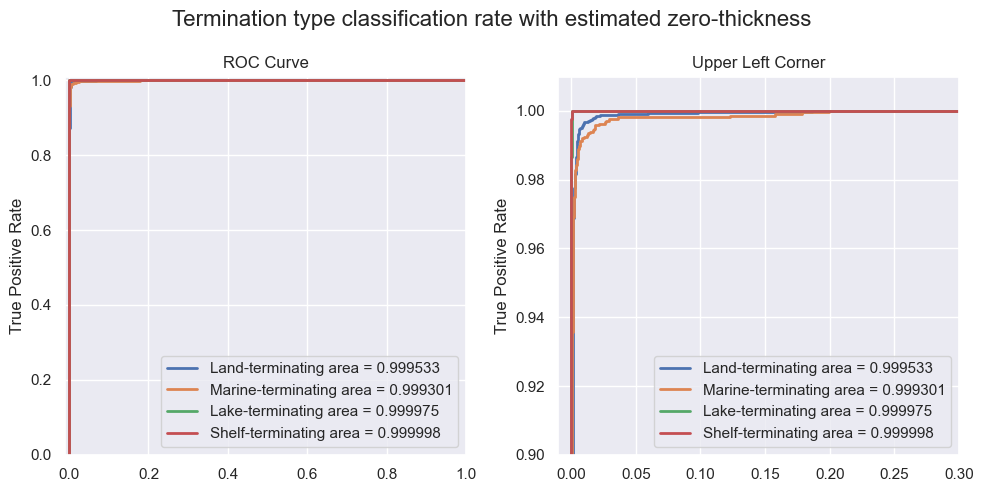

In [13]:
# Assuming your classes are already defined
n_classes = len(classes)
y_test_binarized = label_binarize(yTest, classes=classes)
y_score = pre_prob

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i in range(n_classes):
    ax[0].plot(fpr[i], tpr[i], lw=2, label=f'{glacierTermTypes[int(classes[i])]} area = {roc_auc[i]:.6f}')

ax[0].set_xlim([-0.01, 1.0])
ax[0].set_ylim([0.0, 1.01])
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('ROC Curve')
ax[0].legend(loc='lower right')

for i in range(n_classes):
    ax[1].plot(fpr[i], tpr[i], lw=2, label=f'{glacierTermTypes[int(classes[i])]} area = {roc_auc[i]:.6f}')

ax[1].set_xlim([-0.01, 0.3])
ax[1].set_ylim([0.9, 1.01])
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Upper Left Corner')
ax[1].legend(loc='lower right')

fig.suptitle('Termination type classification rate with estimated zero-thickness', size = 16)

plt.tight_layout()
plt.savefig('roc_class_termtype_n0.png')
plt.show()


In [39]:
def test_overfitting(estimator, score_func, X_train, y_train, X_test, y_test, prob=False):
    if prob:
        y_pred_train = estimator.predict_proba(X_train)
        y_pred_test = estimator.predict_proba(X_test)
    else:        
        y_pred_train = estimator.predict(X_train)
        y_pred_test = estimator.predict(X_test)
    
    accuracy_train = score_func(y_train, y_pred_train)
    accuracy_test = score_func(y_test, y_pred_test)
    accuracy_difference = accuracy_train - accuracy_test
    
    print(f"Training Accuracy: {accuracy_train:.4f}")
    print(f"Test Accuracy: {accuracy_test:.4f}")
    print(f"Accuracy Difference: {accuracy_difference:.4f}")

test_overfitting(bestMLP, accuracy_score, xTrain, yTrain, xTest, yTest, True)

C:\Users\45424\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
C:\Users\45424\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


ValueError: y_true and y_pred contain different number of classes 4, 2. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [0. 1. 2. 5.]

In [47]:
roc_auc_score = bestMLP.predict_proba(xTest)
losstest = log_loss(yTest, pre_prob_test)

pre_prob_train = bestMLP.predict_proba(xTrain)
losstrain = log_loss(yTrain, pre_prob_train)

print(losstest, losstrain)

C:\Users\45424\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
C:\Users\45424\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


4.046563494123924 4.006976240777883
